In [ ]:
firstTime = True
if firstTime:
    print("First time setup")
    %pip install IPython
    %pip install pandas
    %pip install numpy
    %pip install tqdm
    %pip install scikit-learn
    %pip install torch
    %pip install matplotlib
    %pip install seaborn
    %pip install tabulate
    %pip install ipywidgets
    %pip install --upgrade ipywidgets
    %pip install --upgrade jupyter
    firstTime = False

---
# Data Exploration and Processing

In [24]:
# importing datasets
import pandas as pd
import numpy as np
from tabulate import tabulate
books_raw_df = pd.read_csv('data/Books.csv')
book_ratings_raw_df = pd.read_csv('data/Ratings.csv')
books_users_raw_df = pd.read_csv('data/Users.csv')

C:\Users\elley\AppData\Local\Temp\ipykernel_10168\4274114819.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_raw_df = pd.read_csv('data/Books.csv')


In [25]:
# printing the shape of the dataframes
print(f'Books dataframe shape: {books_raw_df.shape}')
print(f'Reviews dataframe shape: {book_ratings_raw_df.shape}')
print(f'Users dataframe shape: {books_users_raw_df.shape}')

print(tabulate(books_raw_df.head(), headers='keys', tablefmt='psql'))
print(tabulate(book_ratings_raw_df.head(), headers='keys', tablefmt='psql'))
print(tabulate(books_users_raw_df.head(), headers='keys', tablefmt='psql'))

Books dataframe shape: (271360, 8)
Reviews dataframe shape: (1149780, 3)
Users dataframe shape: (278858, 3)
+----+------------+----------------------------------------------------------------------------------------------------+----------------------+-----------------------+----------------------------+--------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------------------------+
|    |       ISBN | Book-Title                                                                                         | Book-Author          |   Year-Of-Publication | Publisher                  | Image-URL-S                                                  | Image-URL-M                                                  | Image-URL-L                                                  |
|----+------------+----------------------------------------------------------------------------------------------------+

## Exploratory Data Analysis
#### Distribution of user ratings before a smaller sample is taken.

Text(0.5, 1.0, 'Distribution of Ratings before Sampling')

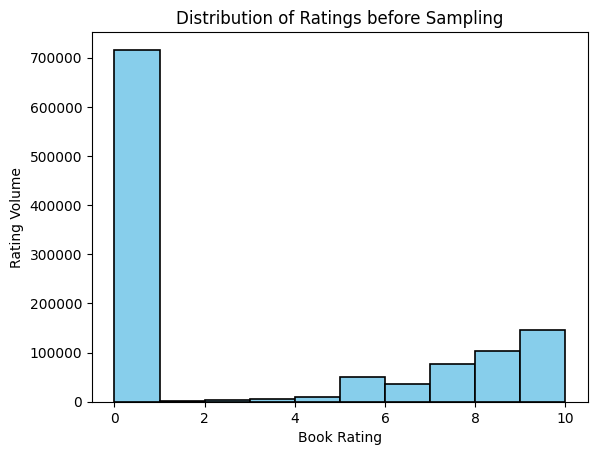

In [35]:
# Plotting the distribution of ratings
import matplotlib.pyplot as plt

# Plotting histogram of ratings
plt.hist(book_ratings_raw_df['Book-Rating'], bins=10, color='skyblue', edgecolor='black', linewidth=1.2)
plt.xlabel('Book Rating')
plt.ylabel('Rating Volume')
plt.title('Distribution of Ratings before Sampling')

---

## Data Loading
#### Sampling the data and storing it in dataframes.

In [36]:
# Size of sampled data
num_books = 100
num_total_ratings = 200

# Data Loading - Getting the top n books based on reviews
top_rated_books = book_ratings_raw_df['ISBN'].value_counts().head(num_books).index
sampled_books_df = books_raw_df[books_raw_df['ISBN'].isin(top_rated_books)]

# Data Loading - Getting ratings of the top n books
book_ISBN = sampled_books_df['ISBN'].unique() # Book ISBNs of the sampled books

full_ratings_df = book_ratings_raw_df[book_ratings_raw_df['ISBN'].isin(book_ISBN)]
sampled_ratings_df = full_ratings_df.groupby('ISBN').head(num_total_ratings)

# Merge ratings with users df to get the age of the user
sampled_ratings_df = pd.merge(sampled_ratings_df, books_users_raw_df, on='User-ID', how='left')

## Data Cleaning
#### Dropping unnecessary or incomplete features. Checking for missing values in sampled dataset.

In [37]:
# Data cleaning - drop unnecessary columns
sampled_books_df = sampled_books_df.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'])
sampled_ratings_df = sampled_ratings_df.dropna(subset=['Age'])
sampled_ratings_df = sampled_ratings_df.drop(columns=['Location'])

# Print the head row of each dataframe
print(tabulate(sampled_books_df.head(1), headers='keys', tablefmt='psql'))
print(tabulate(sampled_ratings_df.head(1), headers='keys', tablefmt='psql'))

# Check dataframes for n/a, null and missing values
print("Check for missing values in the sampled dataframes")
print(sampled_books_df.isnull().sum())
print(sampled_ratings_df.isnull().sum())

+----+------------+---------------+---------------+-----------------------+-------------+
|    |       ISBN | Book-Title    | Book-Author   |   Year-Of-Publication | Publisher   |
|----+------------+---------------+---------------+-----------------------+-------------|
| 18 | 0440234743 | The Testament | John Grisham  |                  1999 | Dell        |
+----+------------+---------------+---------------+-----------------------+-------------+
+----+-----------+------------+---------------+-------+
|    |   User-ID |       ISBN |   Book-Rating |   Age |
|----+-----------+------------+---------------+-------|
|  1 |    276847 | 0446364193 |             0 |    27 |
+----+-----------+------------+---------------+-------+
Check for missing values in the sampled dataframes
ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64
User-ID        0
ISBN           0
Book-Rating    0
Age            0
dtype: int64


### Dataframe Information

In [38]:
# Storing sampled data's book titles, users, and ratings
book_titles = sampled_books_df.set_index('ISBN')['Book-Title'].to_dict()
num_total_books = sampled_books_df['ISBN'].nunique()
num_total_users = sampled_ratings_df['User-ID'].nunique()
num_total_ratings = sampled_ratings_df['Book-Rating'].count()

print(f'Sampled Books dimensions: {sampled_books_df.shape}')
print(f'Sampled Ratings dimensions: {sampled_ratings_df.shape}')

print(f'Total books: {num_total_books}')
print(f'Total ratings: {num_total_ratings}')
print(f'Total users: {num_total_users}')

Sampled Books dimensions: (99, 5)
Sampled Ratings dimensions: (13800, 4)
Total books: 99
Total ratings: 13800
Total users: 5334


---

# Creating Matrix Factorization Model

In [69]:
import torch
import torch.nn as nn

class MFModel(nn.Module):
    def __init__(self, number_users, number_objects, n_factors=20, user_feature_dimensions=10):
        super().__init__()
        
        # Create user and item embeddings
        self.user_factors = nn.Embedding(number_users, n_factors)
        self.object_factors = nn.Embedding(number_objects, n_factors)

        # Create user features layer
        self.user_features_linear = nn.Linear(user_feature_dimensions, n_factors)
        
        # Initialize weights
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.object_factors.weight.data.uniform_(0, 0.05)
        self.user_features_linear.weight.data.uniform_(0, 0.05)
    
    def forward(self, data):
        # Extract user and item IDs
        objects = data[:, 0].long()          
        user_IDs = data[:, 1].long()       
        user_attributes = data[:, 2:]
        
        # Lookup of embeddings
        user_embeddings = self.user_factors(user_IDs)
        item_embeddings = self.object_factors(objects)
        
        # Lookup of user features embeddings
        embeddings_user_features = self.user_features_linear(user_attributes.float()) 
        
        # Combine user embeddings and user features embeddings
        user_features_combined = user_embeddings + embeddings_user_features 

        # Calculate the interaction between the user and the item
        interaction = (user_features_combined * item_embeddings).sum(dim=1)
        
        return interaction


In [70]:
from torch.utils.data.dataloader import Dataset
from torch.utils.data import DataLoader

class PreProcessor(Dataset):
    def __init__(self, books_df, ratings_df):
        # copy ratings dataframe
        self.ratings = ratings_df.copy()

        # getting all user ids and books isbns
        user_ids = ratings_df['User-ID'].unique()
        book_isbns = books_df['ISBN'].unique()

        # creating dictionaries for mappings
        self.user_to_index = {user: idx for idx, user in enumerate(user_ids)}
        self.book_to_index = {game: idx for idx, game in enumerate(book_isbns)}
        self.index_to_user = {idx: user for user, idx in self.user_to_index.items()}
        self.index_to_book = {idx: game for game, idx in self.book_to_index.items()}

        # mapping user ids and book isbns to indexes
        self.ratings['ISBN'] = ratings_df['ISBN'].apply(lambda x: self.book_to_index[x])
        self.ratings['User-ID'] = ratings_df['User-ID'].apply(lambda x: self.user_to_index[x])

        # creating x and y tensors
        self.x = self.ratings[['ISBN','User-ID','Age']].values
        self.y = self.ratings['Book-Rating'].values

        self.x, self.y = torch.tensor(self.x), torch.tensor(self.y)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

### Matrix Factorization Model Hyperparameters

In [142]:
# Model hyperparameters
epochs = 230
batch_size = 132
n_factors = 3
book_feature_dim = 1

# Checking if system GPU is available for training
cuda_core_is_available = torch.cuda.is_available()

# Creating the model
mf_model = MFModel(num_total_users, num_total_books, n_factors, book_feature_dim)
print(mf_model)

if cuda_core_is_available:
    print("Can utilize GPU for training.")
    torch.cuda.empty_cache()
    mf_model = mf_model.cuda()

# Printing accepted model parameters
for item, parameter in mf_model.named_parameters():
    if parameter.requires_grad:
        print(item, parameter.data)

# Model loss function, optimizer, training data, and initial embeddings
MFmodel_loss = torch.nn.MSELoss()
MFmodel_optimizer = torch.optim.Adam(mf_model.parameters(), lr=1e-3)

training_set = PreProcessor(sampled_books_df, sampled_ratings_df)
print("\nTensor head:",training_set[0])
training_set_loader = DataLoader(training_set, batch_size, shuffle=True)

initial_book_embeddings = mf_model.object_factors.weight.data.cpu().numpy().copy()

MFModel(
  (user_factors): Embedding(5334, 3)
  (object_factors): Embedding(99, 3)
  (user_features_linear): Linear(in_features=1, out_features=3, bias=True)
)
user_factors.weight tensor([[0.0116, 0.0096, 0.0163],
        [0.0076, 0.0264, 0.0462],
        [0.0467, 0.0329, 0.0345],
        ...,
        [0.0410, 0.0315, 0.0254],
        [0.0293, 0.0445, 0.0264],
        [0.0349, 0.0068, 0.0005]])
object_factors.weight tensor([[0.0187, 0.0446, 0.0481],
        [0.0441, 0.0252, 0.0167],
        [0.0456, 0.0368, 0.0496],
        [0.0251, 0.0262, 0.0366],
        [0.0078, 0.0166, 0.0070],
        [0.0198, 0.0499, 0.0117],
        [0.0295, 0.0082, 0.0150],
        [0.0402, 0.0059, 0.0138],
        [0.0244, 0.0463, 0.0090],
        [0.0082, 0.0215, 0.0398],
        [0.0197, 0.0419, 0.0185],
        [0.0302, 0.0468, 0.0468],
        [0.0292, 0.0123, 0.0432],
        [0.0209, 0.0474, 0.0349],
        [0.0187, 0.0222, 0.0272],
        [0.0026, 0.0223, 0.0153],
        [0.0245, 0.0303, 0.0362],
  

## Training Matrix Factorization Model

In [143]:
from tqdm.notebook import tqdm_notebook as tqdm 

# matrix factorization training loop
for epoch in tqdm(range(epochs)):
    losses = []

    for x, y in training_set_loader:
        if cuda_core_is_available:
            x, y = x.cuda(), y.cuda()
        
        MFmodel_optimizer.zero_grad()
        y_hat = mf_model(x)
        loss = MFmodel_loss(y_hat.squeeze(), y.type(torch.float32))
        losses.append(loss.item())
        loss.backward()
        MFmodel_optimizer.step()
    print(f'Epoch {epoch}, loss: {sum(losses)/len(losses)}')

  0%|          | 0/230 [00:00<?, ?it/s]

Epoch 0, loss: 26.157296516781763
Epoch 1, loss: 19.42500801994687
Epoch 2, loss: 18.035337057567776
Epoch 3, loss: 17.89654344831194
Epoch 4, loss: 17.830106862386067
Epoch 5, loss: 17.78995099748884
Epoch 6, loss: 17.719093095688592
Epoch 7, loss: 17.64677977789016
Epoch 8, loss: 17.603581019810267
Epoch 9, loss: 17.53924377986363
Epoch 10, loss: 17.48298759460449
Epoch 11, loss: 17.417151650928314
Epoch 12, loss: 17.346981575375512
Epoch 13, loss: 17.26324452899751
Epoch 14, loss: 17.19638442993164
Epoch 15, loss: 17.135172371637253
Epoch 16, loss: 17.020385724022276
Epoch 17, loss: 16.96839166368757
Epoch 18, loss: 16.888763291495188
Epoch 19, loss: 16.780354608808246
Epoch 20, loss: 16.690385673159646
Epoch 21, loss: 16.597599111284527
Epoch 22, loss: 16.50377143678211
Epoch 23, loss: 16.382857876732235
Epoch 24, loss: 16.299808229718888
Epoch 25, loss: 16.183580707368396
Epoch 26, loss: 16.065977269127256
Epoch 27, loss: 15.925062197730655
Epoch 28, loss: 15.805519013177781
Epoch

In [144]:
# converting factor weights tensor to numpy array
trained_book_embeddings = mf_model.object_factors.weight.data.cpu().numpy()

# Visualization 1 - Matrix Factorization Heatmap

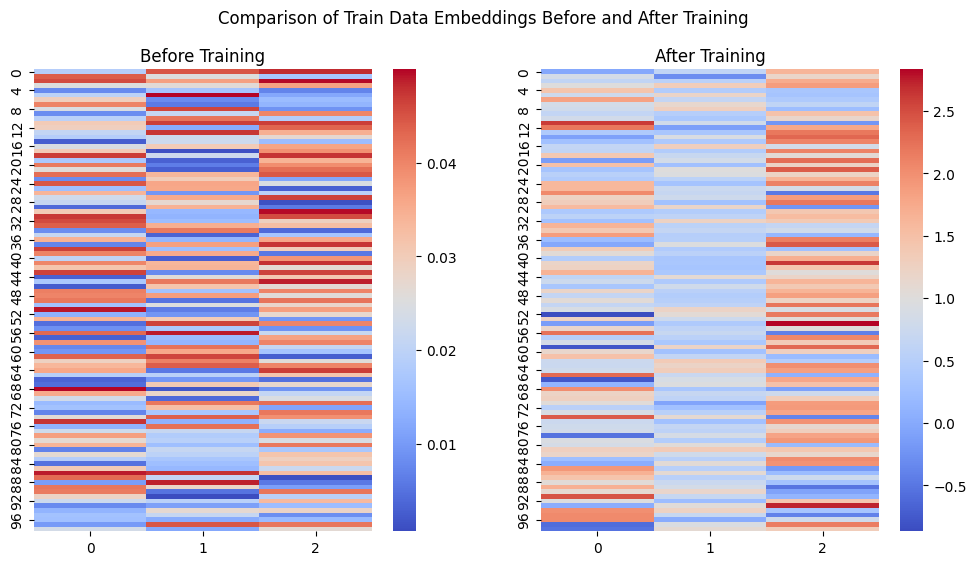

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Creating plots for the embeddings before and after training
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap of data before training
sns.heatmap(initial_book_embeddings, cmap='coolwarm', ax=axs[0])
axs[0].set_title('Before Training')

# Heatmap of the data after training
sns.heatmap(trained_book_embeddings, cmap='coolwarm', ax=axs[1])
axs[1].set_title('After Training')

fig.suptitle('Comparison of Train Data Embeddings Before and After Training')

# Display the plot
plt.show()

---

### K-means Clustering - Elbow Method Visualization
#### - Used to determine the optimal number of clusters to sort books into.

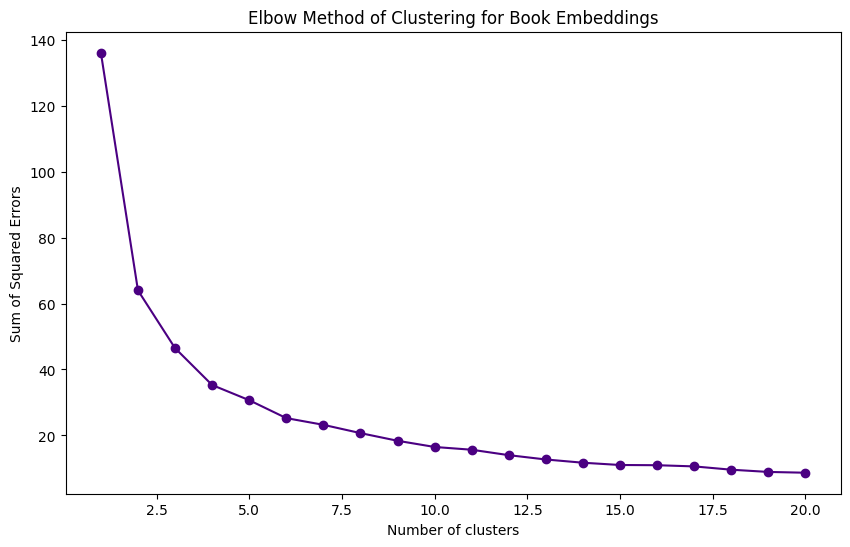

In [158]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate the sum of squared errors for different values of k
sum_sqr_errors = []
for k in range(1, 21):
    k_means_model = KMeans(n_clusters=k, random_state=42).fit(trained_book_embeddings)
    sum_sqr_errors.append(k_means_model.inertia_)

# Plot for clusters vs Sum of Squared Errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), sum_sqr_errors, marker='o', color= 'indigo')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow Method of Clustering for Book Embeddings')

# Display the plot
plt.show()


---

# Visualization #2 - Silhouette Analysis
#### Used to identify the optimal number of clusters for the K-mean clustering model. It also examines distribution of items through clusters, and overall accuracy.

Number of clusters = 2, the average silhouette_score is 0.43107450008392334.
Number of clusters = 3, the average silhouette_score is 0.33399859070777893.
Number of clusters = 4, the average silhouette_score is 0.3152458965778351.
Number of clusters = 5, the average silhouette_score is 0.2770180106163025.
Number of clusters = 6, the average silhouette_score is 0.35016700625419617.
Number of clusters = 7, the average silhouette_score is 0.3248071074485779.
Number of clusters = 8, the average silhouette_score is 0.28349635004997253.
Number of clusters = 9, the average silhouette_score is 0.2742130756378174.


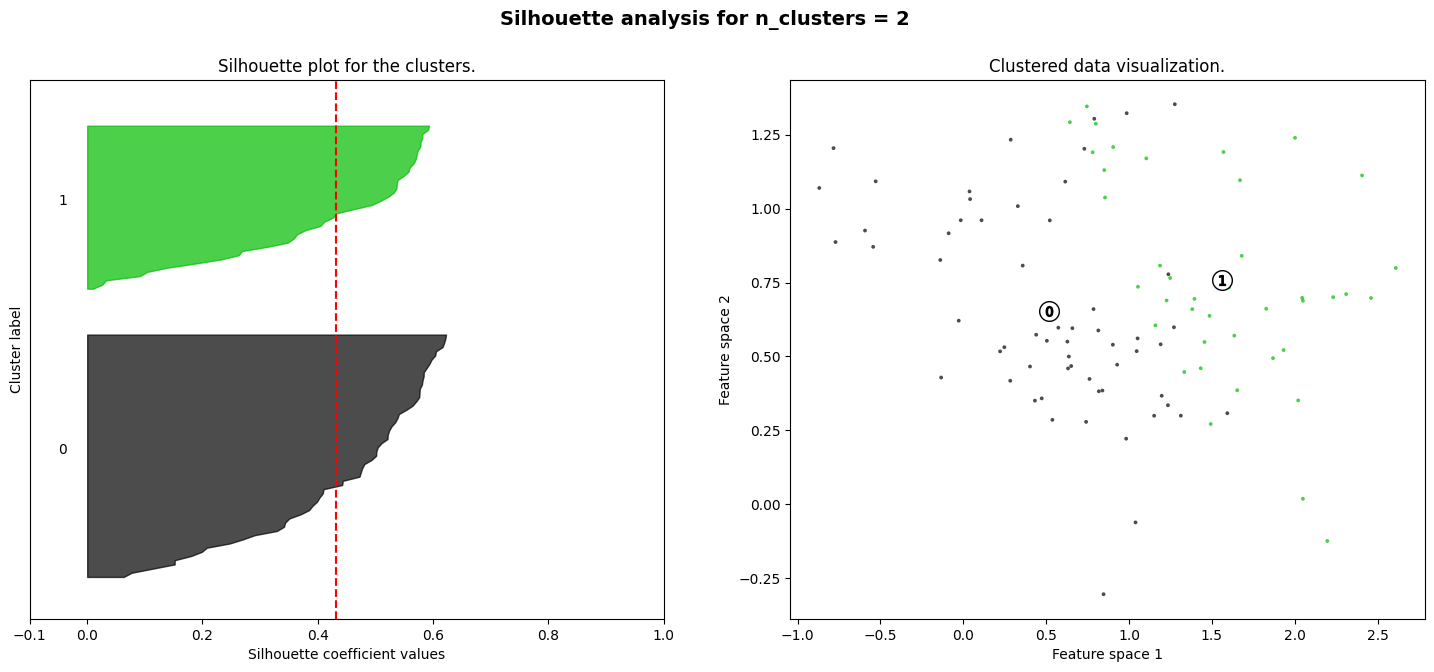

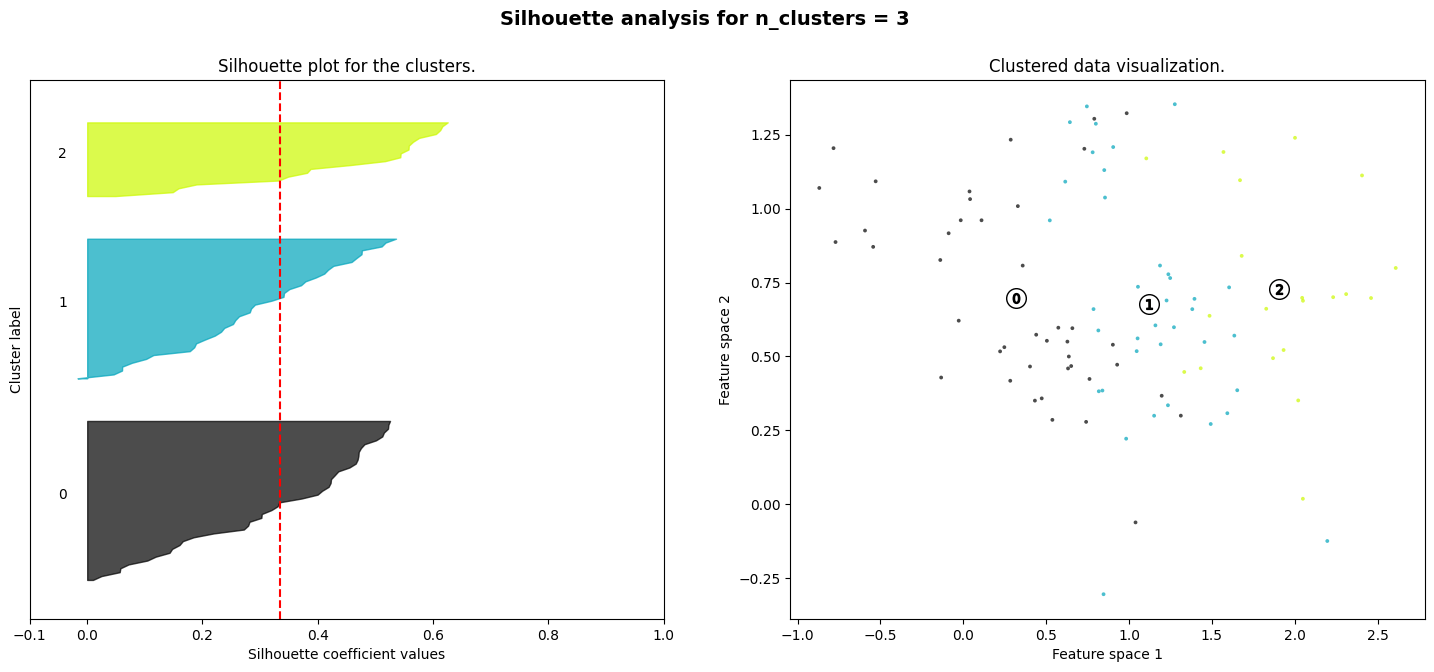

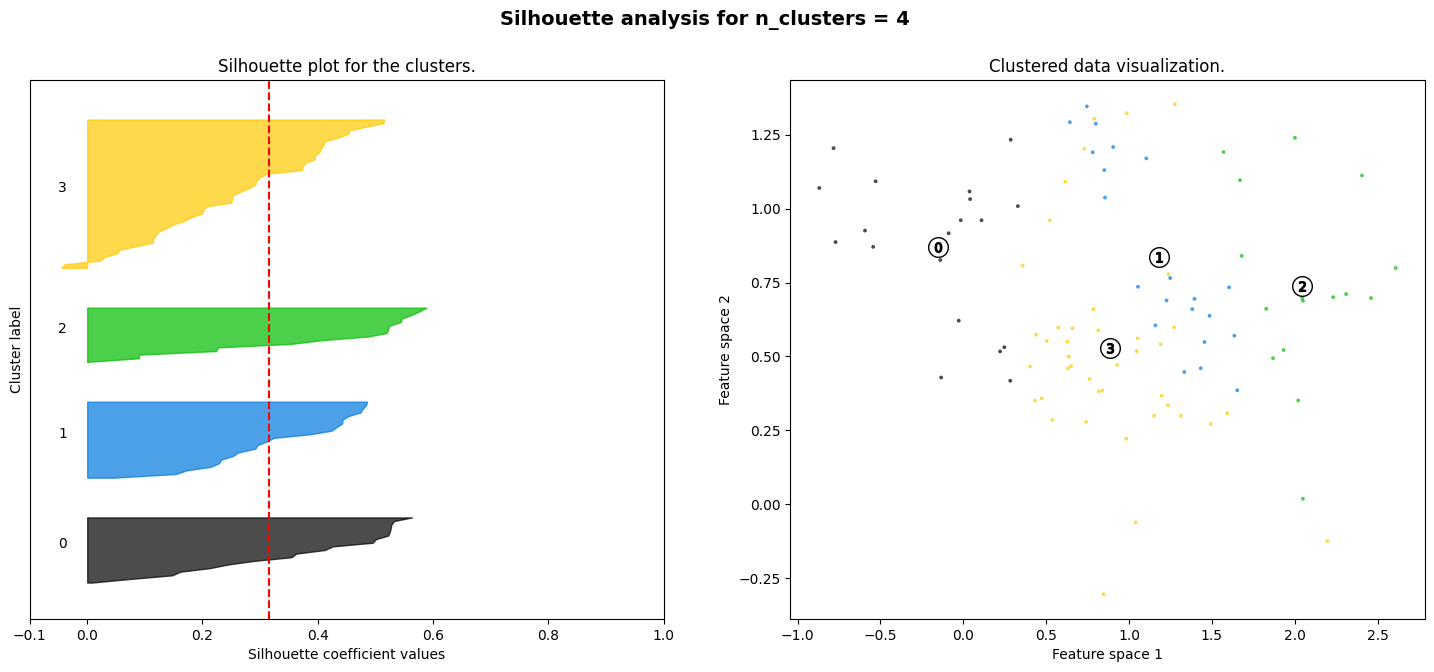

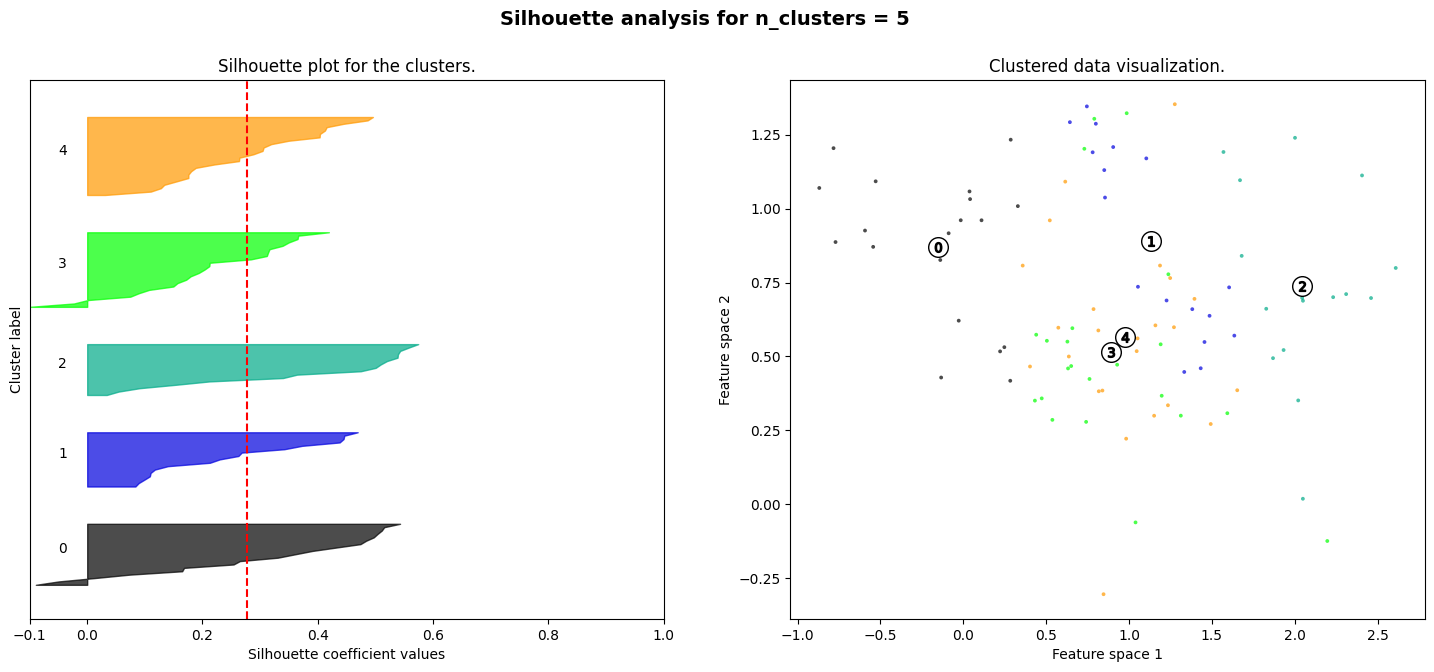

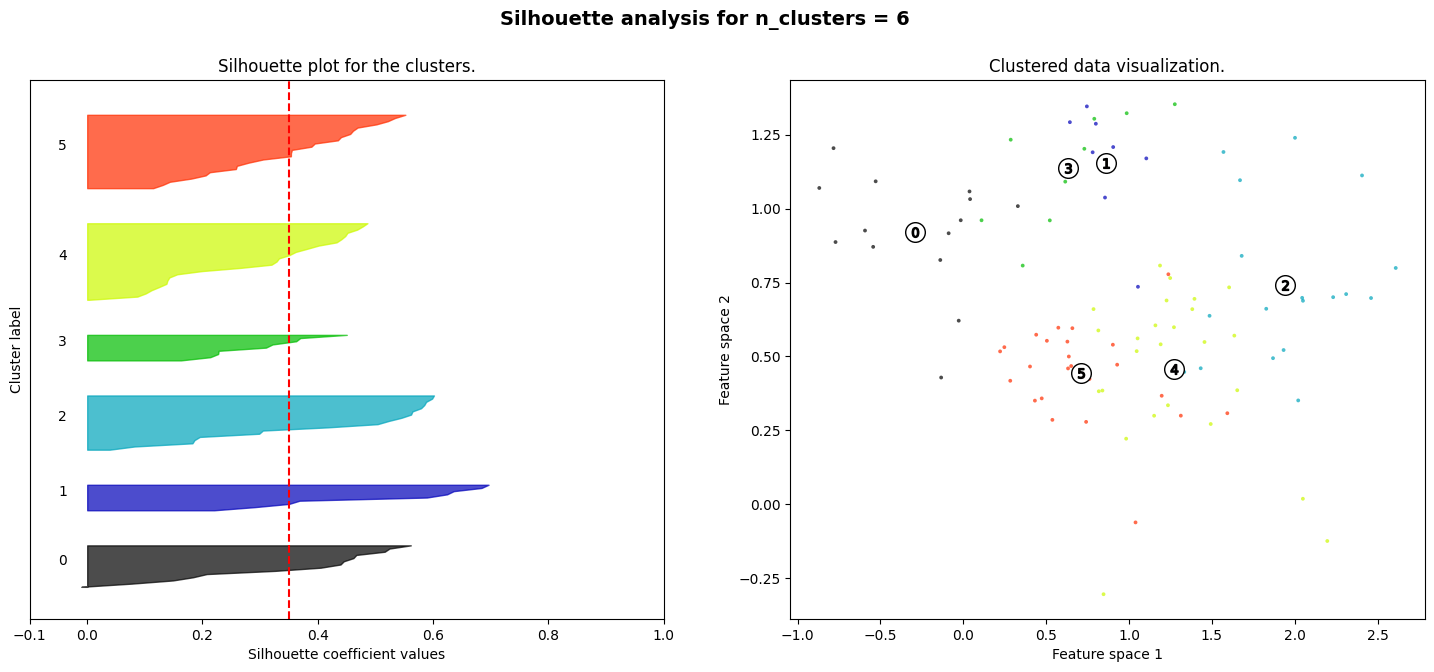

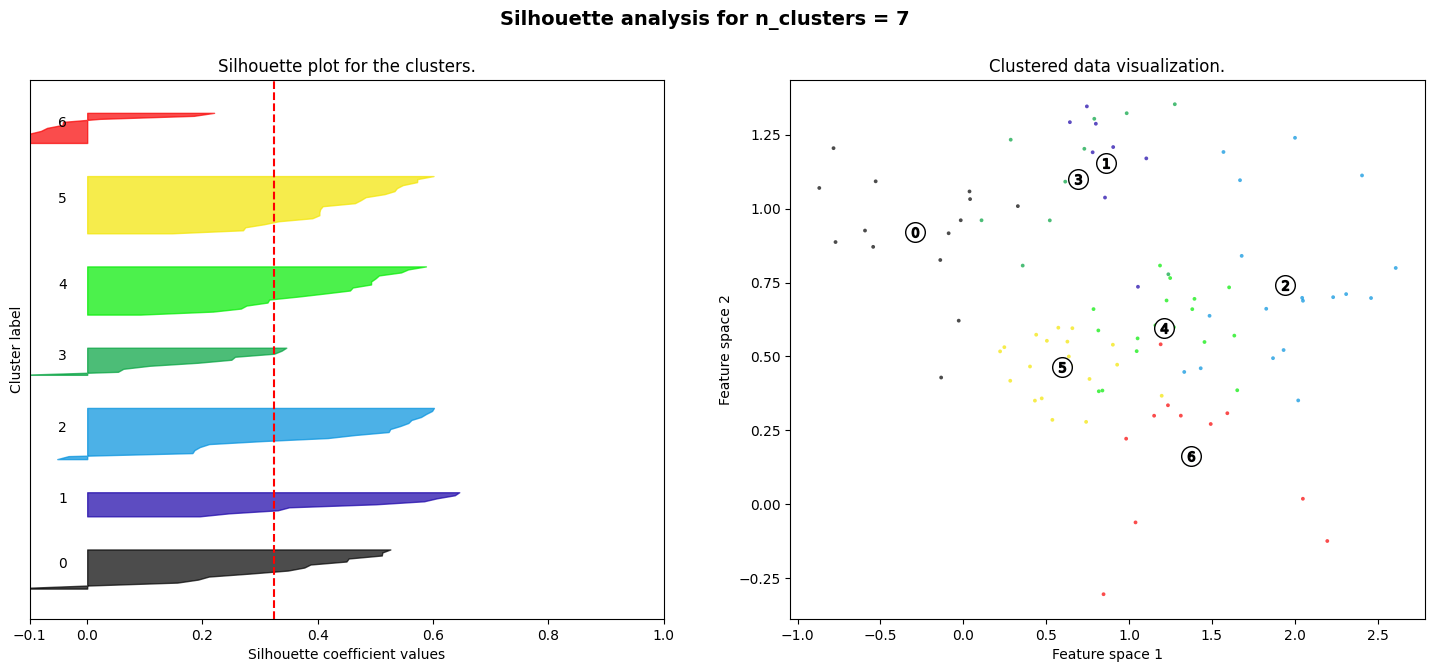

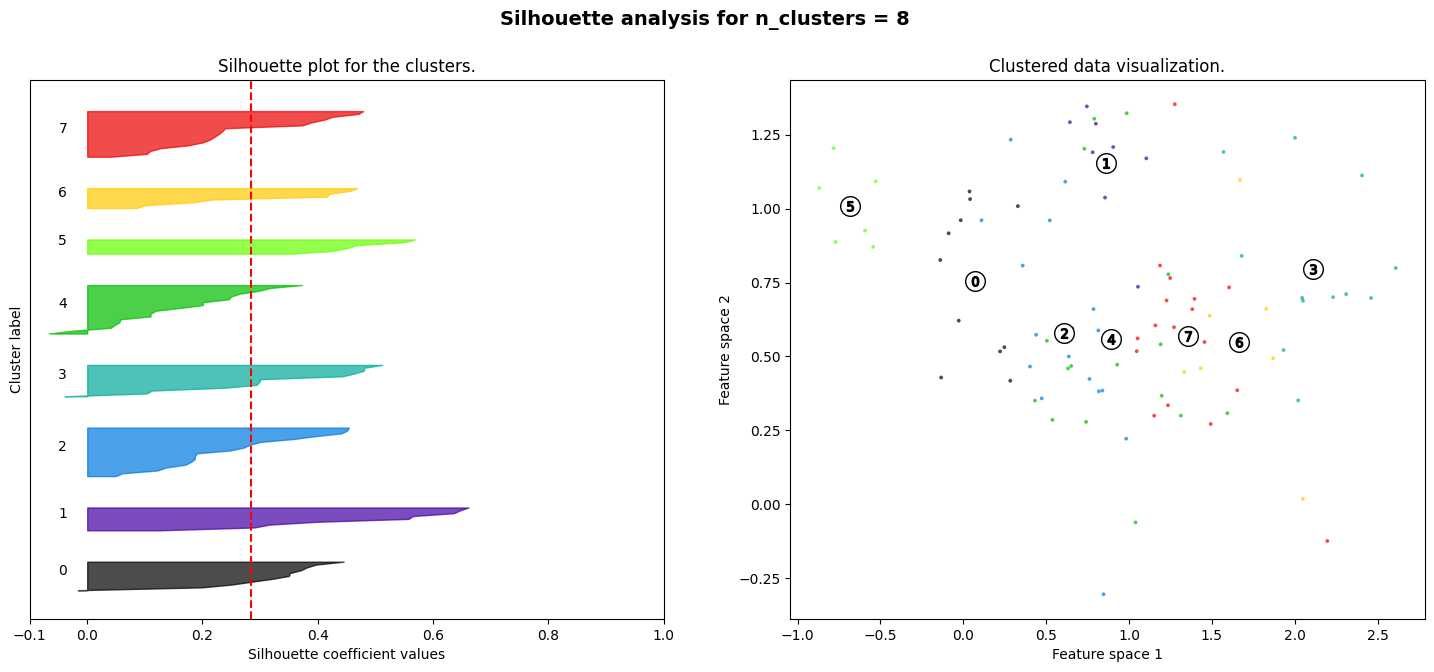

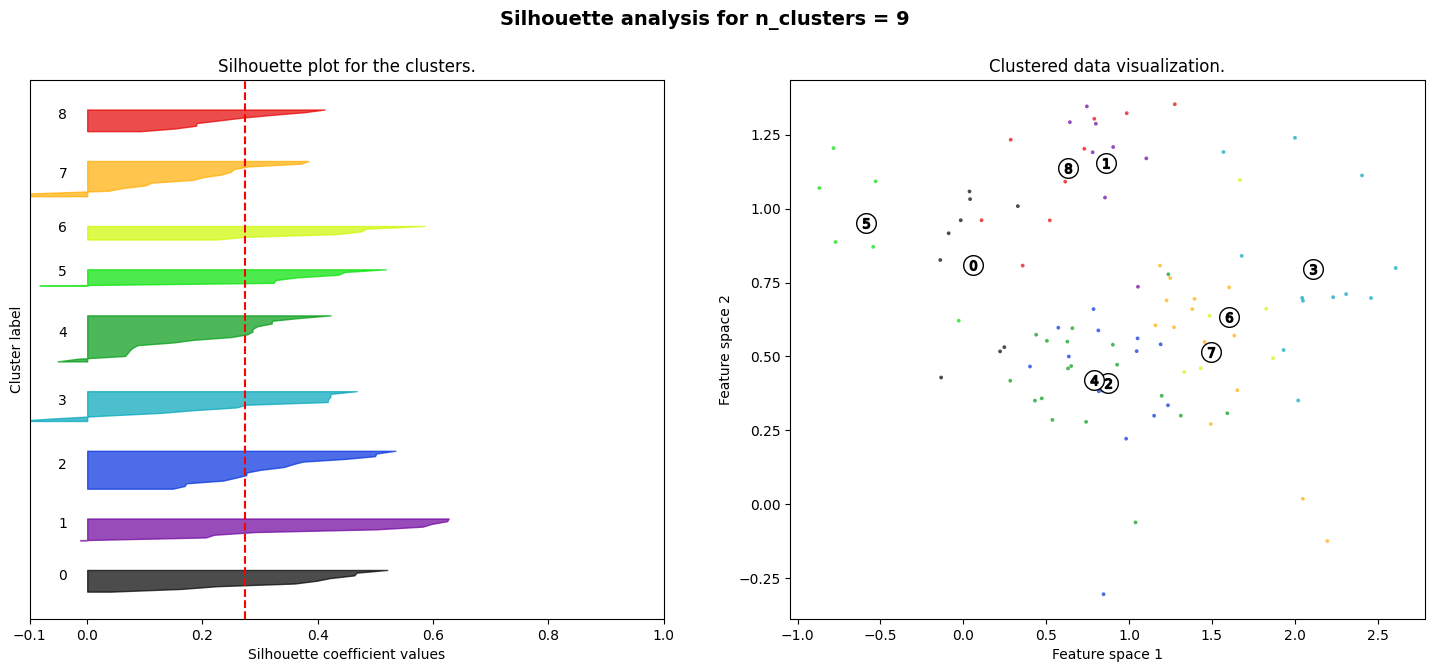

In [147]:
from sklearn.metrics import silhouette_score, silhouette_samples

# creating silhouette plots for different number of clusters
for k in range(2, 10):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(trained_book_embeddings) + (k + 1) * 10])

    clustering_model = KMeans(n_clusters=k, random_state=42)
    book_cluster_labels = clustering_model.fit_predict(trained_book_embeddings)

    avg_silhouette_score = silhouette_score(trained_book_embeddings, book_cluster_labels)
    print(f"{k} clusters, average silhouette_score is {avg_silhouette_score}.")

    # Compute the silhouette scores for each possible cluster
    silhouette_scores = silhouette_samples(trained_book_embeddings, book_cluster_labels)
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = silhouette_scores[book_cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title("Silhouette plot for the clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=avg_silhouette_score, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = plt.cm.nipy_spectral(book_cluster_labels.astype(float) / k)
    ax2.scatter(trained_book_embeddings[:, 0], trained_book_embeddings[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    centers = clustering_model.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Clustered data visualization.")
    ax2.set_xlabel("Feature space 1")
    ax2.set_ylabel("Feature space 2")

    plt.suptitle(("Silhouette analysis for n_clusters = %d" % k), fontsize=14, fontweight='bold')

plt.show()

In [148]:
from sklearn.cluster import KMeans
number_of_clusters = 4

# fitting kmeans model to trained book embeddings
k_means_model = KMeans(n_clusters=number_of_clusters, random_state=42).fit(trained_book_embeddings)

In [149]:
# Initialize a list to hold cluster information
cluster_info = []

# Iterate over clusters
for i in range(number_of_clusters):
    cluster_books = []
    for book_index in np.where(k_means_model.labels_ == i)[0]:
        book_ISBN = training_set.index_to_book[book_index]
        cluster_books.append(book_titles[book_ISBN])
    cluster_info.append({'Cluster': f'Cluster {i}', 'Books': '\n'.join(sorted(cluster_books))})

# Print the cluster information in tabular format
print(tabulate(cluster_info, headers='keys', tablefmt='grid'))

+-----------+---------------------------------------------------------------------------+
| Cluster   | Books                                                                     |
+===========+===========================================================================+
| Cluster 0 | 1st to Die: A Novel                                                       |
|           | A Is for Alibi (Kinsey Millhone Mysteries (Paperback))                    |
|           | A Map of the World                                                        |
|           | Balzac and the Little Chinese Seamstress : A Novel                        |
|           | Cold Mountain : A Novel                                                   |
|           | Empire Falls                                                              |
|           | Fall On Your Knees (Oprah #45)                                            |
|           | Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1)         |
|         

# Cluster Density Visualization
#### Bar chart of the number of books in each cluster.

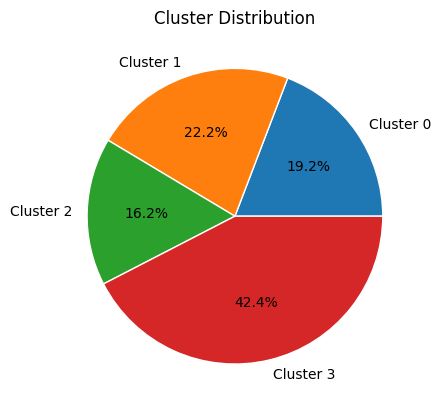

In [150]:
import matplotlib.pyplot as plt

def create_cluster_pie_chart(cluster_labels, cluster_info):
    """
    Creates a pie chart to visualize the distribution of data points in each cluster.

    Parameters:
    - cluster_labels (numpy.ndarray): Array of cluster labels for each data point.
    - cluster_info (list): List of dictionaries containing information about each cluster.

    Returns:
    None
    """

    # Count the number of data points in each cluster
    cluster_counts = [len(cluster_labels[cluster_labels == i]) for i in range(len(cluster_info))]

    # Create a pie chart
    plt.pie(cluster_counts, labels=[cluster['Cluster'] for cluster in cluster_info], autopct='%1.1f%%', wedgeprops=dict(edgecolor='white'))
    plt.title('Cluster Distribution')

    # Display the chart
    plt.show()

# Create a pie chart to visualize the distribution of data points in each cluster
create_cluster_pie_chart(k_means_model.labels_, cluster_info)


# K-means Clustering Groups Visualization

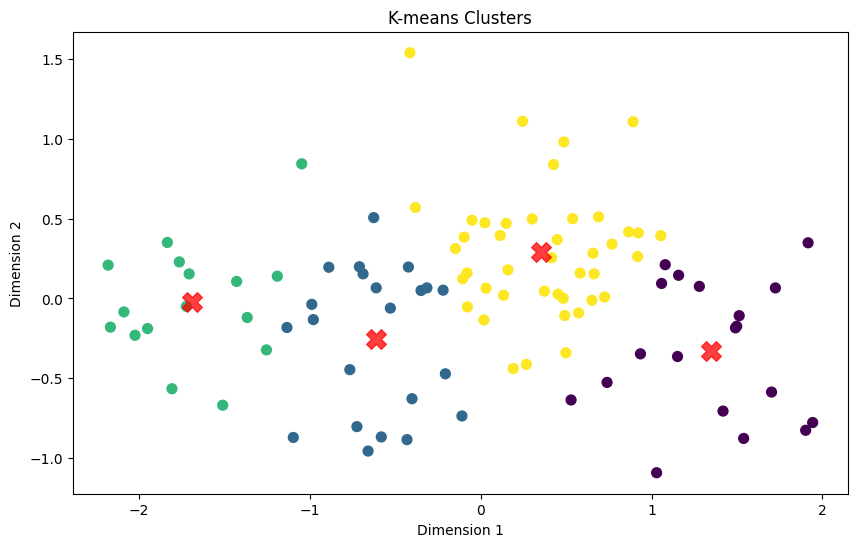

In [151]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_clusters(trained_book_embeddings, kmeans):
    """
    Visualizes the clusters generated by K-means algorithm using PCA for dimensionality reduction.

    Parameters:
    trained_book_embeddings (array-like): The trained book embeddings.
    kmeans (KMeans): The trained K-means model.

    Returns:
    None
    """

    # Get the labels assigned by K-means
    y_kmeans = kmeans.labels_

    # Reduce dimensions with PCA for visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(trained_book_embeddings)

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_kmeans, s=50, cmap='viridis')

    # Plot the centroids
    centers_2d = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', s=200, alpha=0.75, marker='X')

    plt.title('K-means Clusters')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

visualize_clusters(trained_book_embeddings, k_means_model)


In [152]:
import numpy as np
from ipywidgets import widgets
from IPython.display import display, clear_output

# Create a dropdown widget for selecting a book
book_dropdown = widgets.Dropdown(
    options=book_titles.values(),
    description='Book:',
    disabled=False,
)

# Function to get the cluster of the selected book
def get_book_cluster(unique_book_isbn):
    book_ISBN = sampled_books_df[sampled_books_df['Book-Title'] == unique_book_isbn].iloc[0]['ISBN']
    book_index = training_set.book_to_index[book_ISBN]
    book_embedding = trained_book_embeddings[book_index].reshape(1, -1)
    cluster = k_means_model.predict(book_embedding)[0]
    return cluster

# Function to get the books from the same cluster as the selected book
def get_cluster_books(cluster):
    cluster_books = []
    for book_idx in np.where(k_means_model.labels_ == cluster)[0]:
        book_name = training_set.index_to_book[book_idx]
        cluster_books.append(book_titles[book_name])
    return cluster_books

# Function to display the books in the same cluster as the selected book
def display_cluster_books(book_title):
    cluster = get_book_cluster(book_title)
    cluster_books = get_cluster_books(cluster)
    clear_output(wait=True)  # Clear previous output
    display(book_dropdown)  # Re-display the dropdown
    print(f'Books from the same cluster {book_title}:')
    for book in cluster_books:
        print(book)

# Create an event handler for the dropdown widget
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        display_cluster_books(change['new'])

# Attach the event handler to the dropdown widget
book_dropdown.observe(on_change, names='value')

# Display the dropdown widget
display(book_dropdown)

Dropdown(description='Book:', options=('The Testament', 'Wild Animus', 'Timeline', 'To Kill a Mockingbird', 'T…

In [153]:
# write all cells to a file
#!jupyter nbconvert --to script WGU_Capstone.ipynb